In [1]:
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

import matplotlib.pyplot as plt
import dos

In [2]:

simulation_path = './dos/FEMSimuLink'
sim = dos.DOS(simulation_path, show_timing = 2)

INFO:DOS:Reading config from ./dos/FEMSimuLink/dos.yaml
INFO:DOS:New driver: wind_loads
INFO:wind_loads:New output: Gravity
INFO:wind_loads:New output: Distributed
INFO:wind_loads:New output: TopEnd
INFO:wind_loads:New output: Truss
INFO:wind_loads:New output: GIR
INFO:wind_loads:New output: CRING
INFO:wind_loads:New output: M1
INFO:wind_loads:New output: M1Cell
INFO:wind_loads:New output: M2
INFO:wind_loads:New output: M2Cell
INFO:DOS:New driver: FEM
INFO:FEM:New input: OSS_Grav_CS0
INFO:FEM:New input: OSS_AzDrive_F
INFO:FEM:New input: OSS_ElDrive_F
INFO:FEM:New input: OSS_GIRDrive_F
INFO:FEM:New input: OSS_M1_lcl_6F
INFO:FEM:New input: OSS_Cell_lcl_6F
INFO:FEM:New input: OSS_CRING_6F
INFO:FEM:New input: OSS_TopEnd_6F
INFO:FEM:New input: OSS_GIR_6F
INFO:FEM:New input: OSS_Truss_6F
INFO:FEM:New input: MC_M2_lcl_force_6F
INFO:FEM:New input: MC_M2_MacroCell_F_6d
INFO:FEM:New input: MC_M2_PZT_S1_F
INFO:FEM:New input: MC_M2_PZT_S2_F
INFO:FEM:New input: MC_M2_PZT_S3_F
INFO:FEM:New input: MC

SIMCEO server received: Acknowledging connection from SIMCEO client!


In [3]:
sim.start()

INFO:DOS:Pushing configuration to server
INFO:wind_loads:WindLoad
INFO:FEM:FEM
INFO:DOS:Initializing
INFO:wind_loads:None
INFO:FEM:None
INFO:DOS:Running


In [5]:
sim.pctComplete

96

INFO:DOS:Terminating
INFO:wind_loads:Wind loads deleted!
INFO:FEM:FEM deleted


Elapsed time: 477.80923533439636


### Read and plot LOS data

In [6]:
import pickle
import numpy as np
import scipy.io as sio

file_path = "../CUDAIMS-NSEE/datafiles/CUDAIMSsysDt/memorymaps/dgnf.dat"
dgnf_mm = np.memmap(file_path, dtype=np.float32, mode='r+', shape=(21,84))
dgnf = dgnf_mm.view(dtype = np.float32, type = np.ndarray)

OSS_M1_LOS = sim.logs.entries['FEM']['OSS_M1_LOS'].timeSeries[1].T
MC_M2_LOS_6D = sim.logs.entries['FEM']['MC_M2_LOS_6D'].timeSeries[1].T

dec = 10
dt  = OSS_M1_LOS.shape[1]
nt  = dt // dec

LOS_outs = np.memmap('./LOS.dat', dtype=np.float32, mode='w+', shape=(21,dt))
for k in range(dec):
    ki, kii = nt * k, nt * (k + 1)
    if kii < dt:
        outs = np.concatenate((OSS_M1_LOS[:,ki:kii], MC_M2_LOS_6D[:,ki:kii]), axis=0)
    else:
        outs = np.concatenate((OSS_M1_LOS[:,ki:], MC_M2_LOS_6D[:,ki:]), axis=0)
    los  = dgnf @ outs 
    LOS_outs[:,ki:kii] = los[:,:]
    
LOS_sim = sio.loadmat('./LOS.mat')['outs']

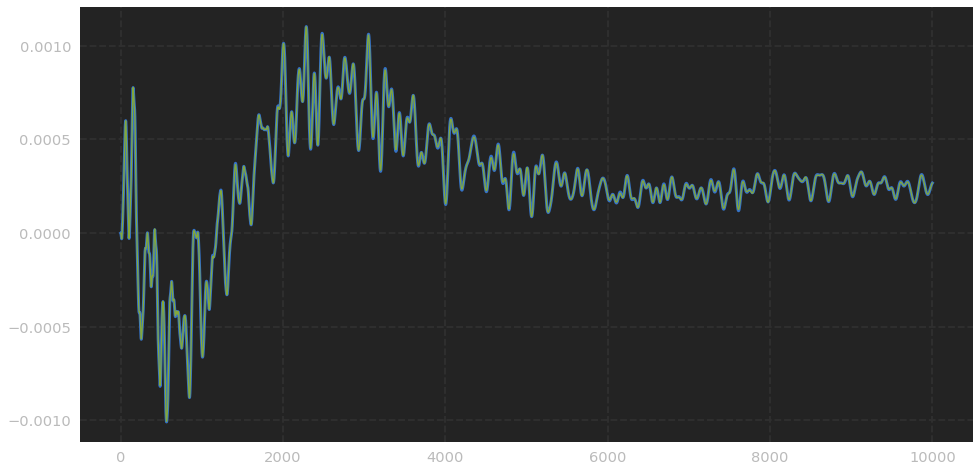

In [7]:
index = 1

signal = LOS_outs[index, :10000]
sim_signal = LOS_sim[index, :10000]

plt.figure(figsize = (16,8))
plt.plot(signal, lw = 3.0)
plt.plot(sim_signal, lw = 1.3)
plt.show()

### Plotting simulation logs

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(*sim.logs.entries['FEM']['OSS_M1_lcl'].timeSeries)
plt.show()

In [ ]:
sim.terminate

In [ ]:
indexes = [2,3,1]

#signal = LOS_outs[index, :]
#sim_signal = LOS_sim[index, :10000]
time = 5*10**(-4) * np.array(range(20000))
plt.figure(figsize = (16,8))
for k in indexes:
    signal = LOS_outs[k, :]
    plt.plot(time,signal, lw = 3.0)
plt.xlabel('Tempo (s)')
plt.ylabel('LOS')
plt.show()

In [ ]:
import h5py
import numpy as np
import scipy.linalg as lalg
from scipy import sparse

data = h5py.File('../database/matmodels/consolidated.mat', 'r')

AG = data['A']
A = sparse.csr_matrix((np.array(AG['data']),AG['ir'],AG['jc']))
A = A.transpose()
B, C = [sparse.csr_matrix(np.array(data[x]).T) for x in list('BC')]
dt = 0.0005

In [ ]:
subsys = A.shape[0] // 2

I_1 = A[:subsys, subsys:].diagonal()
I_2 = A[subsys:, :subsys].diagonal()
I_3 = A[subsys:, subsys:].diagonal()

Ad = np.zeros(A.shape, dtype = np.float32)
Bd = np.zeros(B.shape, dtype = np.float32)

A_ = np.zeros((3,3))
A_[0,1], A_[1,2] = 1, 1
B_ = np.zeros((2,B.shape[1]))
phiGamma = np.zeros((3,3)) 
for k in range(subsys):
    ki = subsys + k
    A_[1,0], A_[1,1] = I_2[k], I_3[k]
    B_[0,:]  = B[k, :].toarray()
    B_[1,:]  = B[ki,:].toarray()
    phiGamma = lalg.expm(A_ * dt)
    
    Ad[k,k],  Ad[k,ki]  = phiGamma[0,0], phiGamma[0,1]
    Ad[ki,k], Ad[ki,ki] = phiGamma[1,0], phiGamma[1,1]
    Bd[k,:]  = phiGamma[0,2] * B[ki,:].toarray()
    Bd[ki,:] = phiGamma[1,2] * B[ki,:].toarray()

In [ ]:
B[5,:].toarray()

In [ ]:
k = 0

In [ ]:
k += 1
k

In [ ]:
from Telescope import Windloads

loads = '../database/loads/WLC0012_IM_v3.mat'
dists = '../database/loads/distributed maxRes M1 WLC0012.mat'

windLoad = Windloads(load_filename=loads, distributed_filename=dists)

In [ ]:
import numpy as np

ndt = 20000
save_var = 'GIR'
y_out = np.zeros((6,ndt))

for k in range(ndt):
    windLoad.Update()
    data = windLoad.Outputs()
    y_out[:,k] = data[save_var]

In [ ]:
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
for k in range(6):
    plt.plot(y_out[k,:], lw=3.0)
plt.show()